Advanced Lane Lines
==

# The flow of pipeline
1. Undistort the image with camera calibration
1. Make binary image by threshold for color conversion and gradients
1. Warp the image to birds eye view
1. Identify lane-line pixels and fit their positions with a polynomial
1. Stabilize the detected result


### Undistort the image with camera calibration

In [1]:
import cv2
import pickle
with open('calib_cam_dist_pickle.p', 'rb') as f:
    cam_calib = pickle.load(f)


def undistort(src, calib):
    return cv2.undistort(src, calib['mtx'], calib['dist'], None, calib['mtx'])


### Make thresholded binary image for lane lines

In [2]:
import numpy as np

def binarize_for_line(src, params):

    def sobel_thresh(gray, params):

        def mag_thresh(sobelx, sobely, thr_min, thr_max):
            # Calculate the gradient magnitude
            gradmag = np.sqrt(sobelx**2 + sobely**2)
            # Rescale to 8 bit
            scale_factor = np.max(gradmag) / 255
            gradmag = (gradmag / scale_factor).astype(np.uint8)
            # Create a binary image of ones where threshold is met, zeros otherwise
            binary_mag = np.zeros_like(gradmag)
            binary_mag[(gradmag >= thr_min) & (gradmag <= thr_max)] = 1
            return binary_mag

        def dir_thresh(sobelx, sobely, thr_min, thr_max):
            # Take the absolute value of the gradient direction,
            # apply a threshold, and create a binary image result
            absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
            binary_dir = np.zeros_like(absgraddir)
            binary_dir[(absgraddir >= thr_min) & (absgraddir <= thr_max)] = 1
            return binary_dir

        gray = cv2.cvtColor(src, cv2.COLOR_RGB2GRAY)
        # Take both Sobel x and y gradients
        kernel_size = params['ksize']
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernel_size)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=kernel_size)
        mag_binary = mag_thresh(sobelx, sobely, *params['mag_thr'])
        dir_binary = dir_thresh(sobelx, sobely, *params['dir_thr'])
        mag_and_dir = np.zeros_like(mag_binary)
        mag_and_dir[(mag_binary == 1) & (dir_binary == 1)] = 1
        return mag_and_dir

    def color_thresh(src, thr_min, thr_max):
        hls = cv2.cvtColor(src, cv2.COLOR_RGB2HLS)
        s_channel = hls[:, :, 2]
        s_binary = np.zeros_like(s_channel)
        s_binary[(s_channel >= thr_min) & (s_channel <= thr_max)] = 1
        return s_binary

    # Combine the two binary thresholds
    grad_binary = sobel_thresh(src, params['sobel'])
    color_binary = color_thresh(src, *params['color_thr'])
    combined_binary = np.zeros_like(grad_binary)
    combined_binary[(grad_binary == 1) | (color_binary == 1)] = 1
    return combined_binary


### Warp the image to birds eye view

In [3]:
class Warper(object):
    def __init__(self, src, dst):
        self.M = cv2.getPerspectiveTransform(src, dst)
        self.M_inv = cv2.getPerspectiveTransform(dst, src)
        return

    def __call__(self, img, inverse=False):
        mtx = self.M if not inverse else self.M_inv
        img_size = (img.shape[1], img.shape[0])
        warped = cv2.warpPerspective(img, mtx, img_size)
        return warped


class LaneWarper():
    def __init__(self, w, h):
        self.src = np.float32(
            [[(w / 2) - 55, h / 2 + 100],
             [((w / 6) - 10), h],
             [(w * 5 / 6) + 60, h],
             [(w / 2 + 55), h / 2 + 100]])

        self.dst = np.float32(
            [[(w / 4), 0],
             [(w / 4), h],
             [(w * 3 / 4), h],
             [(w * 3 / 4), 0]])
        self.warper = Warper(self.src, self.dst)
        return

    def __call__(self, img, inverse=False):
        return self.warper(img, inverse)


###  Identify lane-line pixels and fit their positions with a polynomial

In [4]:
import collections
VISUALIZE = False

class LineDetector(object):
    """ Detect a line of the boundary of the lane.
    The instance of this class detects either left or right line only.
    You need to instantiate for each left and right to detect lane area.
    The input image for this class should be left or right half of the binary warped image """

    def __init__(self, params):
        # HYPERPARAMETERS
        # Choose the number of sliding windows
        self.nwindows = params.get('nwindows', 9)
        # Set the width of the windows +/- margin
        self.margin = params.get('margin', 100)
        # Set minimum number of pixels found to recenter window
        self.minpix = params.get('minpix', 50)
        # Set max number of pixels for rediscovering the lane pixels with sliding window search
        self.rediscover_thr = params.get('rediscover_thr', 50)
        self.fail_num_for_reset = params.get('fail_num_for_reset', 5)

        # Polynomial fit values from the previous frame
        self.fit = None

        # Conversions in x and y from pixels space to meters
        self.ym_per_pix = params.get('ym_per_pix')   # meters per pixel in y dimension
        self.xm_per_pix = params.get('xm_per_pix')   # meters per pixel in x dimension

        self.current_x = None
        # Circular buffer to store x
        self.history_x = collections.deque(maxlen=params.get('history_num', 5))
        self.filtered_x = None  # x filtered from history
        self.curvature_real = 0
        self.position_real = 0

        # Variables for stabilization
        self.reset_needed = True
        self.not_found_count = 0
        self.reset_count = 0  # for debug
        return

    def process(self, binary_warped):
        if self.reset_needed:
            self.reset()
            # Search with sliding window at the fist time
            x, y = self.find_line_pixels(binary_warped)
        else:
            # Search in a margin around the previous line position,
            x, y = self.search_around_poly(binary_warped)
            if len(x) < self.rediscover_thr:
                self.handle_not_found()
                return False

        # Line pixels are detected
        if len(x) < 2:
            print("NO X")
            return False
        self.fit_poly(binary_warped.shape, x, y)
        self.generate_poly_plot(binary_warped.shape[0])
        return True

    def update_result(self, is_valid):
        if not is_valid:
            self.handle_not_found()
            return

        # It is confirmed that the current is valid
        self.not_found_count = 0
        # TODO: update poly coeff for comparison

        self.history_x.append(self.current_x)
        # average history x
        self.filtered_x = sum(self.history_x) / len(self.history_x)
        self.measure_real()
        return

    def handle_not_found(self):
        self.not_found_count += 1
        if self.not_found_count > self.fail_num_for_reset:
            self.reset_needed = True
            self.not_found_count = 0
        return

    def reset(self):
        # Clear history
        self.history_x.clear()
        self.reset_needed = False
        self.reset_count += 1
        return

    def generate_poly_plot(self, height):
        # Generate x and y values for plotting
        # Calc both polynomials using ploty, fit
        ploty = np.linspace(0, height - 1, height)
        self.ploty = ploty
        self.current_x = self.fit[0] * ploty ** 2 + self.fit[1] * ploty + self.fit[2]
        # print('cur', self.current_x[-1])
        return

    def find_line_pixels(self, binary_warped):
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[binary_warped.shape[0] // 2:, :], axis=0)
        if VISUALIZE:
            # Create an output image to draw on and visualize the result
            out_img = np.dstack((binary_warped, binary_warped, binary_warped))
        # Find the peak of the histogram
        # These will be the starting point for the line
        base = np.argmax(histogram)

        # Set height of windows - based on nwindows above and image shape
        window_height = np.int(binary_warped.shape[0] // self.nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated later for each window in nwindows
        x_current = base

        # Create empty lists to receive lane pixel indices
        lane_inds = []

        # Step through the windows one by one
        margin = self.margin
        for window in range(self.nwindows):
            # Identify window boundaries in x and y
            win_y_low = binary_warped.shape[0] - (window + 1) * window_height
            win_y_high = binary_warped.shape[0] - window * window_height
            win_x_low = x_current - margin
            win_x_high = x_current + margin

            if VISUALIZE:
                # Draw the windows on the visualization image
                cv2.rectangle(out_img, (win_x_low, win_y_low), (win_x_high, win_y_high), (0, 255, 0), 2)

            # Identify the nonzero pixels in x and y within the window #
            good_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                         (nonzerox >= win_x_low) & (nonzerox < win_x_high)).nonzero()[0]

            # Append these indices to the lists
            lane_inds.append(good_inds)

            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_inds) > self.minpix:
                x_current = np.int(np.mean(nonzerox[good_inds]))

        # Concatenate the arrays of indices (previously was a list of lists of pixels)
        try:
            lane_inds = np.concatenate(lane_inds)
        except ValueError:
            # Avoids an error if the above is not implemented fully
            pass

        # Extract line pixel positions
        x = nonzerox[lane_inds]
        y = nonzeroy[lane_inds]
        self.nonzeroy = nonzeroy
        self.nonzerox = nonzerox
        self.lane_inds = lane_inds

        return x, y

    def search_around_poly(self, binary_warped):
        margin = self.margin

        # Grab activated pixels
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        # Set the area of search based on activated x-values ###
        # within the +/- margin of our polynomial function ###
        self.lane_inds = ((nonzerox > (self.fit[0]*(nonzeroy**2) + self.fit[1]*nonzeroy + 
                              self.fit[2] - margin)) & (nonzerox < (self.fit[0]*(nonzeroy**2) + 
                              self.fit[1]*nonzeroy + self.fit[2] + margin)))

        # Again, extract line pixel positions
        x = nonzerox[self.lane_inds]
        y = nonzeroy[self.lane_inds]
        self.nonzeroy = nonzeroy
        self.nonzerox = nonzerox
        return x, y

    def fit_poly(self, img_shape, x, y):
        # Fit a second order polynomial to each with np.polyfit() ###
        self.fit = np.polyfit(y, x, 2)
        return

    def get_current_plot(self,):
        return self.current_x, self.ploty

    def get_filtered_plot(self,):
        return self.filtered_x, self.ploty

    def measure_real(self):
        # Calculates the curvature of polynomial functions in meters.
        fit_real = np.polyfit(self.ploty * self.ym_per_pix,
                              self.filtered_x * self.xm_per_pix, 2)
        # Define y-value where we want radius of curvature
        # We'll choose the maximum y-value, corresponding to the bottom of the image
        y_eval = np.max(self.ploty) * self.ym_per_pix
        self.curvature_real = ((1 + (2*fit_real[0]*y_eval + fit_real[1])**2)**1.5) / np.absolute(2*fit_real[0])
        self.position_real = fit_real[0] * y_eval ** 2 + fit_real[1] * y_eval + fit_real[2]
        return

    def visualize(self, binary_warped):
        fitx, ploty = self.get_current_plot()
        margin = self.margin

        # Visualization
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped)) * 255
        window_img = np.zeros_like(out_img)
        # Color in line pixels
        out_img[self.nonzeroy[self.lane_inds], self.nonzerox[self.lane_inds]] = [255, 0, 0]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        line_window1 = np.array([np.transpose(np.vstack([fitx - margin, ploty]))])
        line_window2 = np.array([np.flipud(np.transpose(np.vstack([fitx + margin, ploty])))])
        line_pts = np.hstack((line_window1, line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([line_pts]), (0, 255, 0))

        # Plot the polynomial lines onto the image
        def gen_points(x):
            pts = np.int_(np.dstack((x, ploty)))
            pts = pts.reshape((-1, 1, 2))
            return [pts]
        cv2.polylines(out_img, gen_points(fitx), False, (0, 0, 255), thickness=3)
        # plt.plot(fitx, ploty, color='yellow')
        return cv2.addWeighted(out_img, 1, window_img, 0.3, 0)


In [5]:

class AdvancedLaneFinder(object):
    def __init__(self, width, height, cam_calib, params, binarize_params, line_params):
        self.width = width
        self.height = height
        self.lane_width_valid_thr = params.get('lane_width_valid_thr', 100)
        self.lane_width_diff_thr = params.get('lane_width_diff_thr', 100)

        self.cam_calib = cam_calib
        self.binarize_params = binarize_params

        self.lane_warper = LaneWarper(width, height)

        self.left_l = LineDetector(line_params)
        self.right_l = LineDetector(line_params)
        return

    def process(self, src):
        assert src.shape[:2] == (self.height, self.width)

        undist = undistort(src, self.cam_calib)
        binarized = binarize_for_line(undist, self.binarize_params)
        binary_warped = self.lane_warper(binarized)

        midpoint = self.width // 2
        is_left_detected = self.left_l.process(binary_warped[:, :midpoint])
        is_right_detected = self.right_l.process(binary_warped[:, midpoint:])

        self.binary_warped = binary_warped
        self.undist = undist

        # Validate the result
        if is_left_detected and is_right_detected:
            is_valid_result = self.validate()
        else:
            is_valid_result = False
        # print('validation:{}, L:{}, R:{}'
        #      .format(is_valid_result, is_left_detected, is_right_detected))

        # Feedback the validation result to each line
        if is_left_detected:
            self.left_l.update_result(is_valid_result)
        if is_right_detected:
            self.right_l.update_result(is_valid_result)
        return

    def validate(self):
        left_x, y = self.left_l.get_current_plot()
        right_x, y = self.right_l.get_current_plot()
        if left_x is None or right_x is None:
            return False

        w_far = right_x[0] + self.width // 2 - left_x[0]
        w_near = right_x[-1] + self.width // 2 - left_x[-1]

        result = True
        # Check if the detected lane width is normal
        lane_standard_in_pix = 680
        result &= abs(w_far - lane_standard_in_pix) < self.lane_width_valid_thr
        result &= abs(w_near - lane_standard_in_pix) < self.lane_width_valid_thr

        # Check if the detected lane width goes same from near to far
        result &= abs(w_far - w_near) < self.lane_width_diff_thr
        # print(w_far, w_near)

        return result
        
    def visualize(self, ):
        lane_warped = self.draw_lane(self.binary_warped)
        # Warp the image back to original image space using inverse perspective matrix (Minv)
        lane_orig = self.lane_warper(lane_warped, inverse=True)
        # Combine the result with the original image
        dst = cv2.addWeighted(self.undist, 1, lane_orig, 0.3, 0)

        dst = self.draw_position(dst)
        dst = self.draw_curvature(dst)
        return dst

    def draw_position(self, dst):
        left_pos = self.left_l.position_real
        right_pos = self.left_l.position_real + 3.7  # 3.7m corresponds to half width
        offset = (left_pos + right_pos) / 2 - 3.7
        text = 'Vehicle is {:.2f} meters left of center'.format(offset)
        cv2.putText(dst, text, (10, 100),
                    cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 2, cv2.LINE_AA)
        return dst

    def draw_curvature(self, dst):
        curvature = (self.left_l.curvature_real + self.right_l.curvature_real) / 2
        text = 'Radius of curvature = {:.2f} (m)'.format(curvature)
        cv2.putText(dst, text, (10, 50),
                    cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 2, cv2.LINE_AA)
        return dst

    def draw_lane(self, binary_warped):
        # Create an image to draw the lines on
        warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        # Recast the x and y points into usable format for cv2.fillPoly()
        shape = (self.height, self.width // 2)
        left_fitx, ploty = self.left_l.get_filtered_plot()
        right_fitx, ploty = self.right_l.get_filtered_plot()
        # print('filtered ', left_fitx[-1], right_fitx[-1])
        if left_fitx is None or right_fitx is None:
            return color_warp
        else:
            right_fitx_shifted = right_fitx + shape[1]
            pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
            pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx_shifted, ploty])))])
            pts = np.hstack((pts_left, pts_right))

            # Draw the lane onto the binary_warped blank image
            dst = cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

        return dst


### Parameter values

In [6]:
    BINARIZE_PARAMS = {
        'sobel': {
            'ksize': 15,
            'mag_thr': (50, 100),
            'dir_thr': (0.85, 1.15),
        },
        'color_thr': (150, 255),
    }

    LINE_PARAMS = {
        'margin': 100,
        'minpix': 50,
        'nwindows': 9,
        'rediscover_thr': 50,
        'ym_per_pix': 30 / 720,
        'xm_per_pix': 3.7 / 700,
        'history_num': 5,
        'fail_num_for_reset': 5,
    }

    FINDER_PARAMS = {
        'lane_width_valid_thr': 200,
        'lane_width_diff_thr': 200,
    }

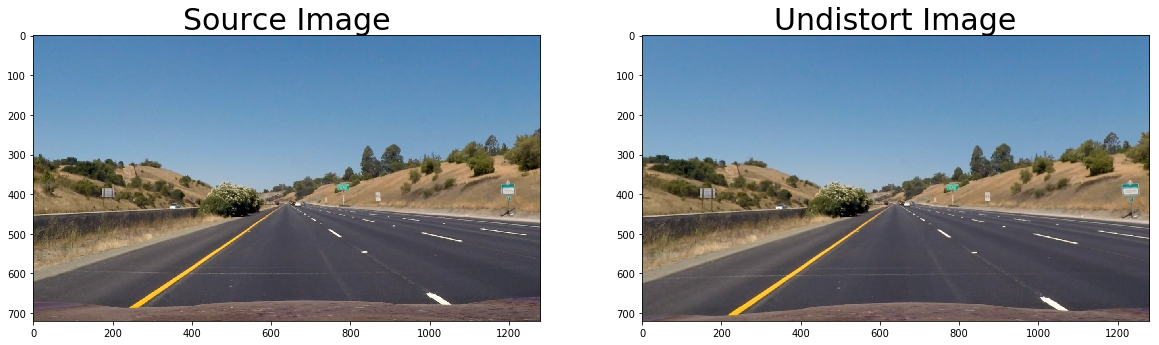

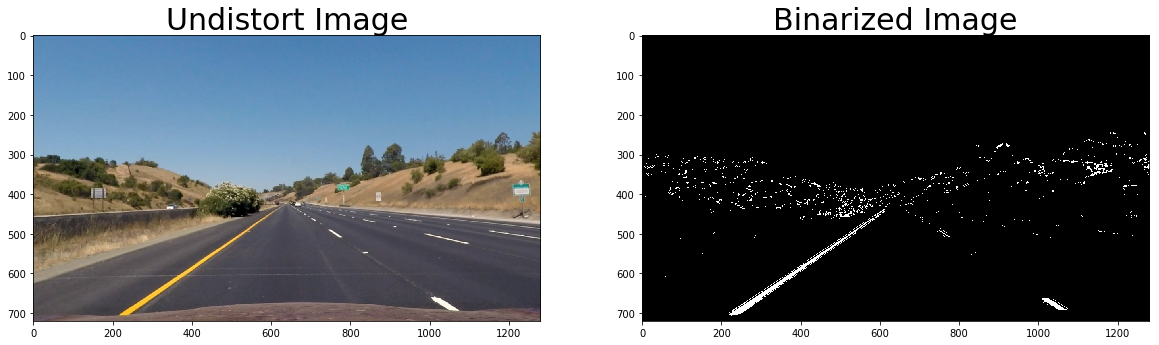

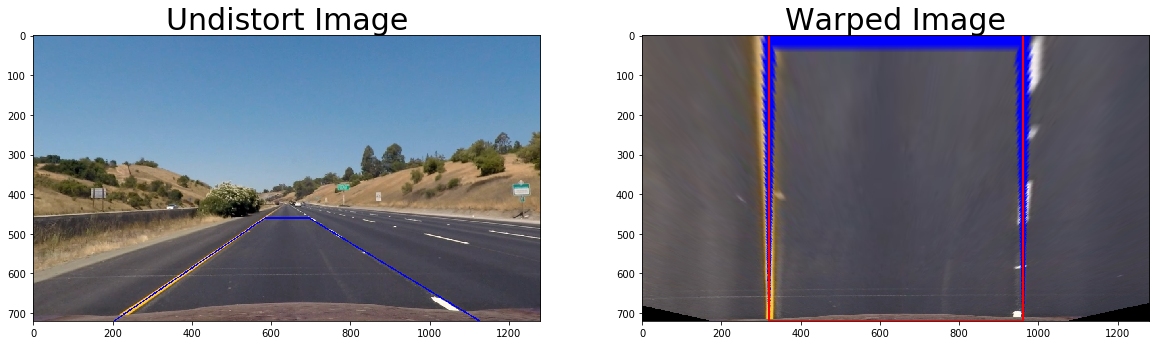

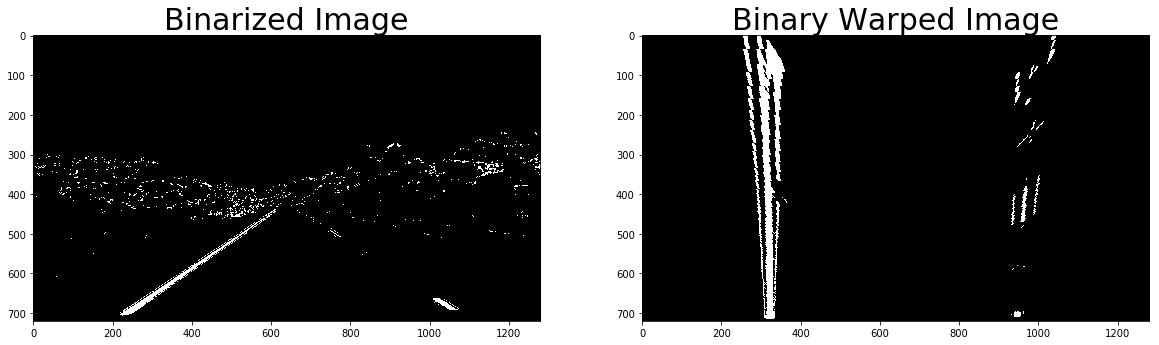

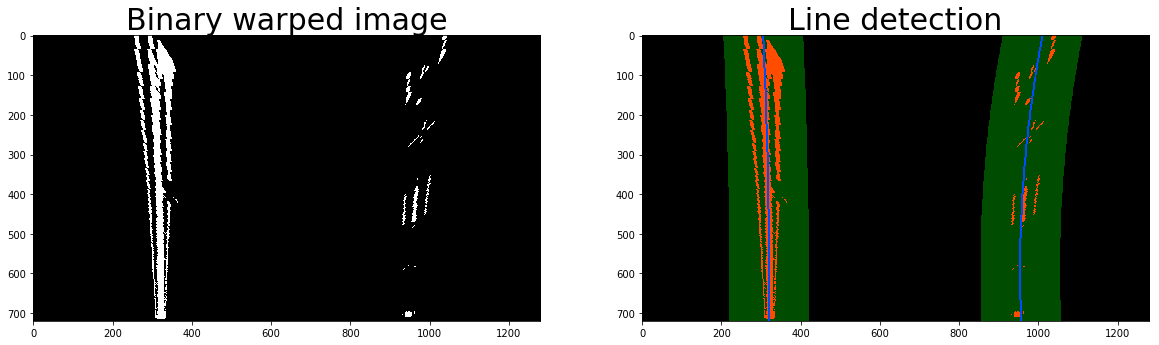

In [7]:
def show_example():
    %matplotlib inline
    import matplotlib.pyplot as plt

    src = cv2.imread('test_images/straight_lines1.jpg')
    src = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
    undistort_img = undistort(src, cam_calib)

    # Show undistort image
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    ax1.imshow(src)
    ax1.set_title('Source Image', fontsize=30)
    ax2.imshow(undistort_img)
    ax2.set_title('Undistort Image', fontsize=30)
    plt.show()
    
    # Show binarized image
    binarized = binarize_for_line(undistort_img, BINARIZE_PARAMS)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    ax1.imshow(undistort_img)
    ax1.set_title('Undistort Image', fontsize=30)
    ax2.imshow(binarized, cmap='gray')
    ax2.set_title('Binarized Image', fontsize=30)
    plt.show()

    # Draw src of warp M in red
    lane_warper = LaneWarper(src.shape[1], src.shape[0])
    pts = lane_warper.src.astype(np.int32)
    pts = pts.reshape((-1,1,2))
    undistort_img = cv2.polylines(undistort_img, [pts], True, (0, 0, 255), thickness=2)
    
    # Show warped image
    warped = lane_warper(undistort_img)

    # Draw dst of warp M in blue
    pts = lane_warper.dst.astype(np.int32)
    pts = pts.reshape((-1,1,2))
    dst= cv2.polylines(warped, [pts], True, (255, 0, 0), thickness=3)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    ax1.imshow(undistort_img)
    ax1.set_title('Undistort Image', fontsize=30)
    ax2.imshow(warped)
    ax2.set_title('Warped Image', fontsize=30)
    plt.show()
    
    # Show binary_warped image
    binary_warped = lane_warper(binarized)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    ax1.imshow(binarized, cmap='gray')
    ax1.set_title('Binarized Image', fontsize=30)
    ax2.imshow(binary_warped, cmap='gray')
    ax2.set_title('Binary Warped Image', fontsize=30)
    plt.show()
    
    # Show line detection
    def get_line_detection_image(half_src):
        detector = LineDetector(LINE_PARAMS)
        detector.process(half_src)
        return detector.visualize(half_src)
    
    midpoint = binary_warped.shape[1] // 2
    left_dst = get_line_detection_image(binary_warped[:, :midpoint])
    right_dst = get_line_detection_image(binary_warped[:, midpoint:])

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    ax1.imshow(binary_warped, cmap='gray')
    ax1.set_title('Binary warped image', fontsize=30)
    ax2.imshow(np.hstack([left_dst, right_dst]))
    ax2.set_title('Line detection', fontsize=30)
    plt.show()   
    
    return

show_example()


### Pipeline execution

#### Set up

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

def setup():
    pipeline = AdvancedLaneFinder(1280, 720, cam_calib,
                                  FINDER_PARAMS, BINARIZE_PARAMS, LINE_PARAMS)
    def process_frame(img):
        pipeline.process(img)
        return pipeline.visualize()
    return process_frame


#### Process still picture

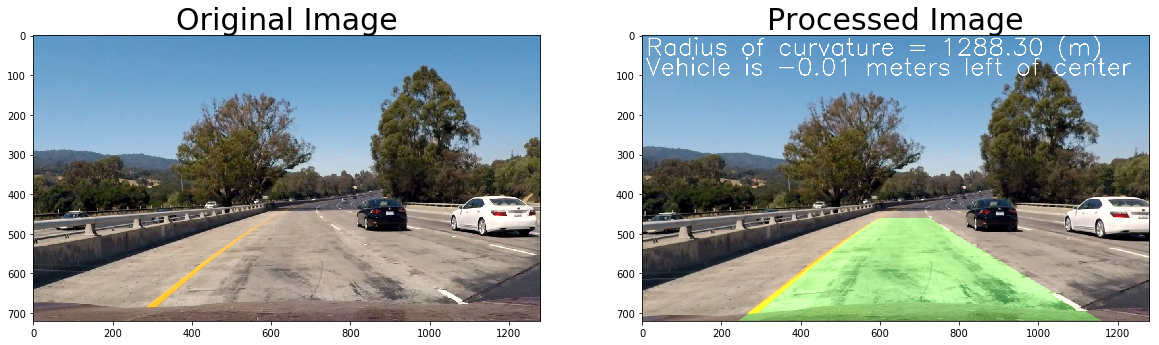

In [9]:
src = cv2.imread('test_images/test1.jpg')
# src = cv2.imread('test_images/project_video_Moment_6.jpg')
src = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
pipeline_func = setup()
dst = pipeline_func(src)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(src)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
# ax2.imshow(dst, cmap='gray')
ax2.set_title('Processed Image', fontsize=30)

In [11]:
def process_all_images(src_dir, dst_dir):
    import os, glob
    for file_path in glob.glob('{}/*.jpg'.format(src_dir)):
        src = cv2.imread(file_path)
        src = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
        pipeline_func = setup()
        dst = pipeline_func(src)
        dst = cv2.cvtColor(dst, cv2.COLOR_RGB2BGR)
        cv2.imwrite(os.path.join(dst_dir, os.path.basename(file_path)), dst)
    return

process_all_images('test_images', 'output_images')

#### Process video

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

pipeline_func = setup()

clip_name = 'project_video.mp4'
# clip1 = VideoFileClip("test_videos/" + clip_name).subclip(23, 25)
clip1 = VideoFileClip("test_videos/" + clip_name)
out_clip = clip1.fl_image(pipeline_func) #NOTE: this function expects color images!!
%time out_clip.write_videofile('output_videos/' + clip_name, audio=False)

